In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx_gdf import read_gdf
import pandas as pd
import random

# Pregunta 1

In [12]:
def calcular_fiedler(matriz_adyacencia):
    A = np.array(matriz_adyacencia)
    D = np.diag(A.sum(axis=1))
    L = D - A

    valores_propios, vectores_propios = np.linalg.eig(L)
    
    indices_ordenados = np.argsort(valores_propios)
    valores_propios_ordenados = valores_propios[indices_ordenados]
    vectores_propios_ordenados = vectores_propios[:, indices_ordenados]
    
    valor_de_fiedler = valores_propios_ordenados[1]
    vector_propio_fiedler = vectores_propios_ordenados[:, 1]
    y = L.view
    
    return valor_de_fiedler, vector_propio_fiedler

In [13]:
Ady = [
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 0]
]

valor_de_fiedler, vector_propio_fiedler = calcular_fiedler(Ady)
print("El valor de Fiedler es:", valor_de_fiedler)
print("El vector propio asociado es:", vector_propio_fiedler)

El valor de Fiedler es: 0.34032095848177074
El vector propio asociado es: [-0.46724728 -0.46724728 -0.30823323  0.11469308  0.27370712  0.33957289
  0.5147547 ]


In [14]:
np.set_printoptions(precision=2, suppress=True, linewidth=100)
A = np.array(Ady)
D = np.diag(A.sum(axis=1))
L = D - A
print(L)

[[ 2 -1 -1  0  0  0  0]
 [-1  2 -1  0  0  0  0]
 [-1 -1  3 -1  0  0  0]
 [ 0  0 -1  3 -1 -1  0]
 [ 0  0  0 -1  2 -1  0]
 [ 0  0  0 -1 -1  3 -1]
 [ 0  0  0  0  0 -1  1]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


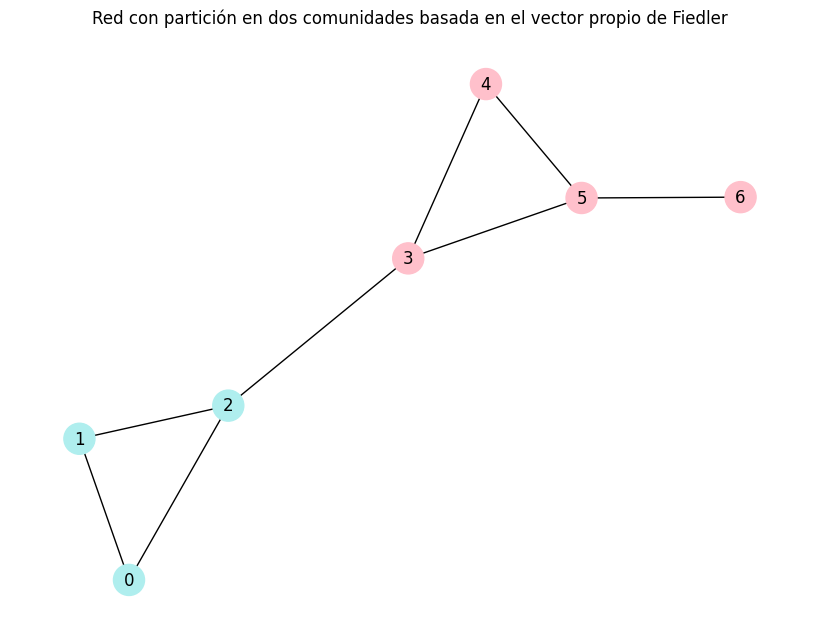

In [15]:
G = nx.from_numpy_array(A)

color_map = []
for value in vector_propio_fiedler:
    if value < 0:
        color_map.append('paleturquoise')
    else:
        color_map.append('pink')


pos = nx.spring_layout(G)  
plt.figure(figsize=(8, 6))

nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, cmap=plt.cm.coolwarm)


plt.title('Red con partición en dos comunidades basada en el vector propio de Fiedler')
plt.show()

# Pregunta 3

In [16]:
gnutella = read_gdf("Datos/gnutella.gdf")
delfines = nx.read_pajek("Datos/delfines.net")

In [31]:
def giant_component_size(G):
    return len(max(nx.connected_components(G), key=len))

def remove_nodes_random_recalc(G):
    G_copy = G.copy()
    initial_size = giant_component_size(G_copy)
    target_size = initial_size / 2
    nodes = list(G.nodes)
    random.shuffle(nodes)
    removed_nodes = 0
    while giant_component_size(G_copy) > target_size and nodes:
        node = nodes.pop()
        G_copy.remove_node(node)
        removed_nodes += 1
    return removed_nodes, G_copy

def remove_nodes_degree_recalc(G):
    G_copy = G.copy()
    initial_size = giant_component_size(G_copy)
    target_size = initial_size / 2
    removed_nodes = 0
    while giant_component_size(G_copy) > target_size and len(G.nodes) > 0:
        degrees = nx.degree(G_copy)
        node = max(degrees, key=lambda x: x[1])[0]
        G_copy.remove_node(node)
        removed_nodes += 1
    return removed_nodes, G_copy

# Función para eliminar nodos en orden de betweenness decreciente y recalcular componentes
def remove_nodes_betweenness_recalc(G):
    G_copy = G.copy()
    initial_size = giant_component_size(G_copy)
    target_size = initial_size / 2
    removed_nodes = 0
    while giant_component_size(G_copy) > target_size and len(G_copy.nodes) > 0:
        betweenness = nx.betweenness_centrality(G_copy)
        node = max(betweenness, key=betweenness.get)
        G_copy.remove_node(node)
        removed_nodes += 1
    return removed_nodes, G_copy

# Generar las redes Erdős-Rényi con la misma cantidad de nodos y densidad de aristas
def generate_er_network(G):
    n = G.number_of_nodes()
    p = nx.density(G)
    return nx.erdos_renyi_graph(n, p)

er_gnutella = generate_er_network(gnutella)
er_delfines = generate_er_network(delfines)

# Analizar ataques
networks = {
    "Gnutella": gnutella,
    "Delfines": delfines,
    "Erdos-Rényi Gnutella": er_gnutella,
    "Erdos-Rényi Delfines": er_delfines
}

for name, G in networks.items():
    initial_nodes = G.number_of_nodes()
    
    random_removed, _ = remove_nodes_random_recalc(G)
    degree_removed, _ = remove_nodes_degree_recalc(G)
    betweenness_removed, _ = remove_nodes_betweenness_recalc(G)
    
    print(f"{name}:")
    print(f"  Nodos iniciales: {initial_nodes}")
    print(f"  Eliminación aleatoria: {random_removed} nodos ({random_removed/initial_nodes:.2%})")
    print(f"  Eliminación por grado: {degree_removed} nodos ({degree_removed/initial_nodes:.2%})")
    print(f"  Eliminación por betweenness: {betweenness_removed} nodos ({betweenness_removed/initial_nodes:.2%})\n")

Gnutella:
  Nodos iniciales: 795
  Eliminación aleatoria: 265 nodos (33.33%)
  Eliminación por grado: 24 nodos (3.02%)
  Eliminación por betweenness: 25 nodos (3.14%)

Delfines:
  Nodos iniciales: 62
  Eliminación aleatoria: 26 nodos (41.94%)
  Eliminación por grado: 15 nodos (24.19%)
  Eliminación por betweenness: 8 nodos (12.90%)

Erdos-Rényi Gnutella:
  Nodos iniciales: 795
  Eliminación aleatoria: 194 nodos (24.40%)
  Eliminación por grado: 65 nodos (8.18%)
  Eliminación por betweenness: 41 nodos (5.16%)

Erdos-Rényi Delfines:
  Nodos iniciales: 62
  Eliminación aleatoria: 27 nodos (43.55%)
  Eliminación por grado: 19 nodos (30.65%)
  Eliminación por betweenness: 18 nodos (29.03%)



# Pregunta 6

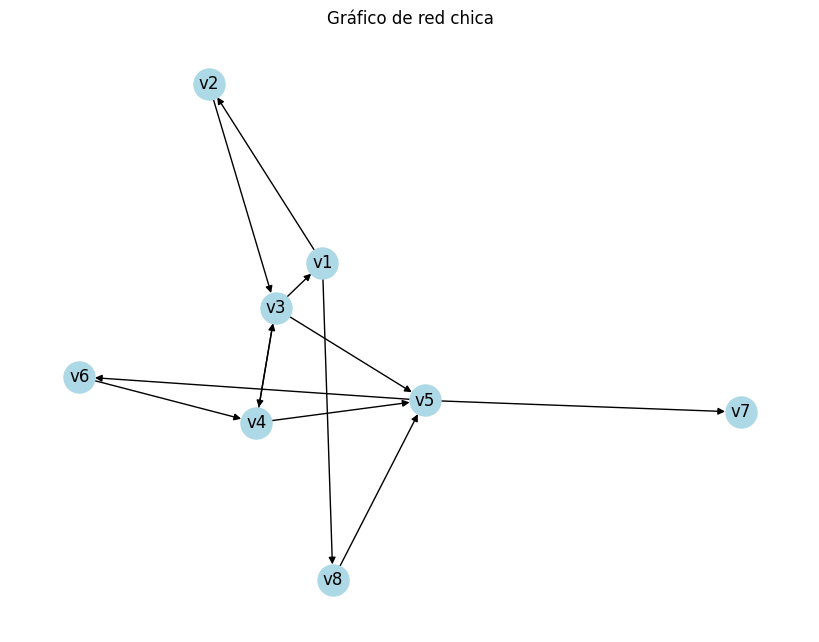

In [17]:
# Builds NetworkX graph object from file.
G6 = read_gdf("Datos/redchica.gdf")

pos = nx.spring_layout(G6)
plt.figure(figsize=(8, 6))

nx.draw(G6, pos, with_labels=True, node_size=500, node_color="lightblue")

plt.title("Gráfico de red chica")
plt.show()

In [20]:
import pandas as pd
in_degree = dict(G6.in_degree())
betweenness = nx.betweenness_centrality(G6)
pagerank = nx.pagerank(G6)
df = pd.DataFrame({
    'Node': list(G6.nodes()),
    'In-Degree': [in_degree[node] for node in G6.nodes()],
    'Betweenness': [betweenness[node] for node in G6.nodes()],
    'PageRank': [pagerank[node] for node in G6.nodes()]
})
df

,Node,In-Degree,Betweenness,PageRank
0,v1,1,0.238095,0.077725
1,v2,1,0.047619,0.064579
2,v3,2,0.428571,0.162980
3,v4,2,0.309524,0.180098
4,v5,3,0.357143,0.209159
5,v6,1,0.214286,0.120440
6,v7,1,0.000000,0.120440
7,v8,1,0.071429,0.064579
